## Paquetes necesarios

In [5]:
#(env base)
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import pytesseract
from pytesseract import Output 
import re

import numpy as np
import math 

**coches**  

https://www.cnet.com/a/img/resize/916b6d1260fda7bfefff6815db067c8c0bddacbd/hub/2022/05/23/74855cdd-4e1f-4f10-b020-e1a1f5c3e091/mission-impossible-dead-reckoning-fiat-500.jpg?auto=webp&width=1920
https://www.autoscout24.hu/cms-content-assets/4mRqexZHAiJ3w3PKvDZUbd-b9c7319d12e14024ce14ecc7b39b0aa8-fiat-500-l-01-1100.jpg

In [6]:
# Si la ruta de Tesseract no está en el PATH, ruta al ejecutable
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

#### References  
https://inside-machinelearning.com/en/yolov8-how-to-use/  
https://inside-machinelearning.com/en/bounding-boxes-python-function/  
https://docs.ultralytics.com/


## Yolo stuff

In [7]:
# Carga del modelo YOLO
model = YOLO('yolov8n.pt')  # implementación de YOLO cargada

# Nombre de las distintas clases
classNames = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck", "boat",
              "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat",
              "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
              "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat",
              "baseball glove", "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup",
              "fork", "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange", "broccoli",
              "carrot", "hot dog", "pizza", "donut", "cake", "chair", "sofa", "pottedplant", "bed",
              "diningtable", "toilet", "tvmonitor", "laptop", "mouse", "remote", "keyboard", "cell phone",
              "microwave", "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase", "scissors",
              "teddy bear", "hair drier", "toothbrush"
              ]



## Detecta Coche (Yolo basic)

In [8]:
# Ruta de la imagen a procesar
img_path = "Images/" # + 'coche2.jpg'

# Leer la imagen
img = cv2.imread(img_path + 'coche1.jpg')
#img = cv2.imread('test3.jpg')

# Perform inference on an image
results = model(img, stream=True)

# Variable para indicar si se detectó un coche
car_detected = False

# Para cada detección
for r in results:
    boxes = r.boxes

    for box in boxes:
        # Contenedor
        x1, y1, x2, y2 = box.xyxy[0] 
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2) # convert to int values
        print(x1,y1,x2,y2)

        # Confianza
        confidence = math.ceil((box.conf[0]*100))/100
        print("Confidence --->",confidence)

        # Clase
        cls = int(box.cls[0])
        print("Class name -->", classNames[cls])
        
        # Si la clase detectada es un coche
        if classNames[cls] == "car":        

            # Convierte identificador numérico de clase a un color RGB
            escala = int((cls / len(classNames)) * 255 * 3)
            print('escala: ',escala,cls , len(classNames))
            if escala >= 255*2:
                R = 255
                G = 255
                B = escala - 255*2
            else:
                if escala >= 255:
                    R = 255
                    G = escala - 255
                    B = 0
                else:
                    R = escala
                    G = 0
                    B = 0

            # Dibuja el contenedor y clase
            cv2.rectangle(img, (x1, y1), (x2, y2), (R, G, 255), 3)
            cv2.putText(img, classNames[cls] , [x1, y1], cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            print('B: ', B)

            # Si se detecta un coche, actualiza la variable
            car_detected = True
            car_r = img[y1:y2, x1:x2]

            x1_car, y1_car, x2_car, y2_car = x1,y1,x2,y2
            
            #show_image('car', car_r)

    cv2.imshow('car', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

#car_r = img
#alt = car_r.shape[0]
#lar = car_r.shape[1]

# Tamaño imágenes
#size  = (lar,alt)    #larghezza, altezza
    
# Visualización de las imágenes
def show_image(window_name, image):
    alt = image.shape[0]
    lar = image.shape[1]
    # Tamaño imágenes
    size  = (lar,alt)    #larghezza, altezza
    resized_image = cv2.resize(image, size)
    cv2.imshow(window_name, resized_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
show_image('car_fine', car_r)   

print(x1_car, y1_car, x2_car, y2_car)


75 107 779 506
Confidence ---> 0.91
Class name --> car
escala:  19 2 80
B:  0
0 1 72 158
Confidence ---> 0.73
Class name --> truck
108 0 347 135
Confidence ---> 0.72
Class name --> truck
0: 480x640 1 car, 2 trucks, 575.2ms
Speed: 16.2ms preprocess, 575.2ms inference, 36.9ms postprocess per image at shape (1, 3, 480, 640)
75 107 779 506


#### Intento 1 - Placa
Buscando la region aplicando escala de gris + threshold + la funcion findContours()  
y luego en la mitad inferior el contorno ma largo

In [9]:
if car_detected:
    # Convertimos la imagen a escala de grises
    gray = cv2.cvtColor(car_r, cv2.COLOR_BGR2GRAY)
    show_image('Escala de grises', gray)

    # Aplicamos un threshold
    thresh = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY_INV)[1]
    show_image('Threshold', thresh)

    # Buscamos los contornos presentes
    contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    #print(contours)
    canvas = np.zeros_like(car_r)
    cv2.drawContours(canvas, contours, -1, (0, 255, 0), 2)
    show_image('Bordes', canvas)

    # Filtrar contornos en la mitad inferior de la imagen
    height, width = car_r.shape[:2]
    lower_half_contours = [cnt for cnt in contours if (cv2.boundingRect(cnt)[1] > height // 2)] #and \
                           #(cv2.boundingRect(cnt)[0] > width // 3 and cv2.boundingRect(cnt)[0] < width-(width // 3))]
    print('lower half: ', height // 2)
    print('central-third: ', width // 3,width-(width // 3), '\n')

    # Ordenar contornos por área (de mayor a menor)
    lower_half_contours = sorted(lower_half_contours, key=cv2.contourArea, reverse=True)
    
    # Obtener el contorno más grande
    if lower_half_contours:
        largest_contour = lower_half_contours[0]
        #print('largest contour', largest_contour)

        # Visualización del contorno más grande
        canvas = np.zeros_like(car_r)
        cv2.drawContours(canvas, [largest_contour], -1, (0, 255, 0), 2)
        show_image('Contorno mas grande en la mitad inferior', canvas)

        # Extraer la región correspondiente al contorno más grande
        x, y, w, h = cv2.boundingRect(largest_contour)
        #region = cv2.rectangle(gray,(x,y),(x+w,y+h),(0,255,0),2)
        
        region = car_r[y:y+h,x:x + w]

        # Mostrar la matrícula
        show_image('Region Matricula', region)
        #cv2.imshow('region', region)

        # Utilizar pytesseract para la detección de texto en la imagen preprocesada
        #text = pytesseract.image_to_string(region_of_interest, config=custom_config)
        text = pytesseract.image_to_string(region)
        print(text)
        print("Matricula detectada:", text)

else:
    print("No se detectó un coche en la imagen.")

lower half:  199
central-third:  234 470 


Matricula detectada: 


#### Intento 2 - Placa
Buscando la region aplicando escala de gris + canny + la funcion findContours()
y luego en la mitad inferior el contorno ma largo

In [28]:
def detector_plate(image, show_plot=True):
    # Guardamos imagen en variable
    car = cv2.imread("Images/" + image)

    # Ruta de la imagen a procesar
    img_path = "Images/" # + 'coche1.jpg'
    # Leer la imagen
    img = cv2.imread(img_path + image)
    #show_image('img', img)
    car = img

    # Detectar coches
    results_cars = model_car(car, verbose=False)

    # Para cada detección de coche
    for r_car in results_cars:
        boxes_car = r_car.boxes

        for box_car in boxes_car:
            # Si la clase es un coche
            if int(box_car.cls[0]) == 2:
                # Coordenadas del cuadro del coche
                x1_car, y1_car, x2_car, y2_car = box_car.xyxy[0]

                # Definir la región inferior para buscar matrículas
                roi_bottom = car[int((y1_car + y2_car) / 2):int(y2_car), int(x1_car):int(x2_car)]

                #show_image('car', car)
                #show_image('roi_bottom', roi_bottom)
            
                # Convertir la región a escala de grises
                gray_roi_bottom = cv2.cvtColor(roi_bottom, cv2.COLOR_BGR2GRAY)

                #show_image('edge', gray_roi_bottom)

                # Obtener bordes con canny
                edges = cv2.Canny(gray_roi_bottom, 30, 200)

                # Obtener contornos
                cnts, new = cv2.findContours(edges.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

                # Obtener los 30 primeros contornos con mayor área
                cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:30]
                image_copy = roi_bottom.copy()

                # Dibujar los contornos en la imagen
                _ = cv2.drawContours(image_copy, cnts, -1, (255,0,255),2)

                #if show_image:
                    #plot_images(roi_bottom, gray_roi_bottom, 'lower part', 'grayscale')    
                    #plot_images(edges,image_copy,'edges', 'contours')

                plate = None
                for c in cnts:
                    # Obtener el perímetro y el número de bordes
                    perimeter = cv2.arcLength(c, True)
                    edges_count = cv2.approxPolyDP(c, 0.02 * perimeter, True)
                    # Si el contorno tiene 4 vértices, es una matrícula

                    if len(edges_count) == 4:
                        x,y,w,h = cv2.boundingRect(c)
                        # Ajustamos las coordenadas de la matricula al tamaño original de la imagen
                        x, y, w, h = int(x + x1_car), int(y + (y1_car + y2_car) / 2), int(w), int(h)                
                        plate = car[y:y+h, x+0:x+w]
                        break

                # Dibuja el contenedor y clase
                cv2.rectangle(car, (int(x1_car), int(y1_car)), (int(x2_car), int(y2_car)), (0, 0, 255), 4)
                cv2.putText(car, "car" , [int(x1_car), int(y1_car)], cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 5)

                cv2.rectangle(car, (x, y),(x+w, y+h), (0, 255, 0), 4)
                #print(x,y,h,w)

                # Si se ha detectado una matrícula se muestra en RGB
                car = cv2.cvtColor(car, cv2.COLOR_BGR2RGB)
                #plate = cv2.cvtColor(plate, cv2.COLOR_BGR2RGB)

                if plate is not None:
                    plot_images(car,edges,image_copy, plate,'car', 'plate')

                text = pytesseract.image_to_string(plate, config='--psm 8', output_type=Output.STRING)

    #text = plate_validation(text)

    print("\n[+] MATRÍCULA DETECTADA:", text) 

#### show image (openCV)

In [11]:
# Visualización de las imágenes
def show_image(window_name, image):
    #resized_image = cv2.resize(image, desired_size)
    #cv2.imshow(window_name, resized_image)
    cv2.imshow(window_name, image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()

def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image,
                label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2),
                0,
                lw / 3,
                txt_color,
                thickness=tf,
                lineType=cv2.LINE_AA)


#### Plot Image (matplotlib)

In [18]:
# Método que coloca mas imágenes en una misma figura
def plot_images(img1, img2,img3,img4, title1="", title2=""):
    fig = plt.figure(figsize=[15,15])
    ax1 = fig.add_subplot(141)
    ax1.imshow(img1, cmap="gray")
    ax1.set(xticks=[], yticks=[], title=title1)
    ax2 = fig.add_subplot(142)
    ax2.imshow(img2, cmap="gray")
    ax2.set(xticks=[], yticks=[], title=title2)
    ax3 = fig.add_subplot(143)
    ax3.imshow(img3, cmap="gray")
    ax3.set(xticks=[], yticks=[], title=title2)
    ax4 = fig.add_subplot(144)
    ax4.imshow(img4, cmap="gray")
    ax4.set(xticks=[], yticks=[], title=title2)


    plt.show()

#### Método para corregir formato de la matrícula (matrícula española)

In [13]:
def plate_validation(plate):
    # Definir el patrón de la matrícula "0000 AAA"
    plate_pattern = re.compile(r'^\d{4}\s[A-Z]{3}$')

    if plate_pattern.match(plate):
        # La matrícula cumple con el formato
        return plate
    else:
        # La matrícula no cumple con el formato, intentar corregirla
        plate_refactored = re.sub(r'^\s*.*?(\d{4}\s[A-Z]{3}).*$', r'\1', plate)
        return plate_refactored
    
# Cargamos el modelo de YOLO
model_car = YOLO('Models/yolov8n.pt')

# Guardamos la ruta absoluta de tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:/Program Files/Tesseract-OCR/tesseract'    

#### Test

--- Ejemplo 1 ---


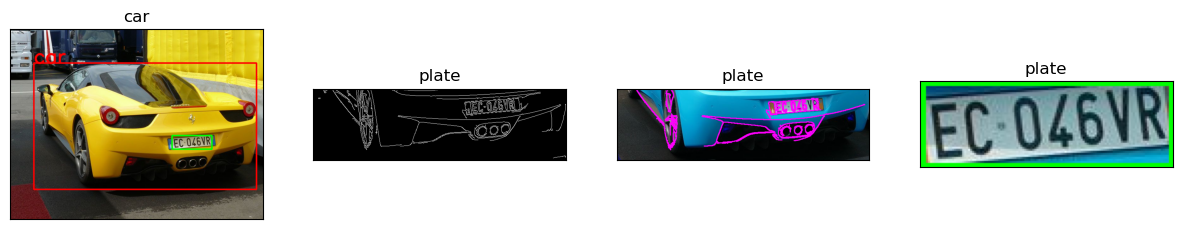


[+] MATRÍCULA DETECTADA: EC O46VR

--- Ejemplo 2 ---


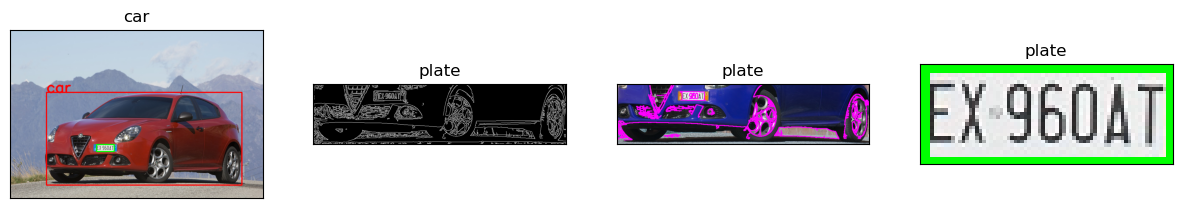


[+] MATRÍCULA DETECTADA: EX-960AT|

--- Ejemplo 3 ---


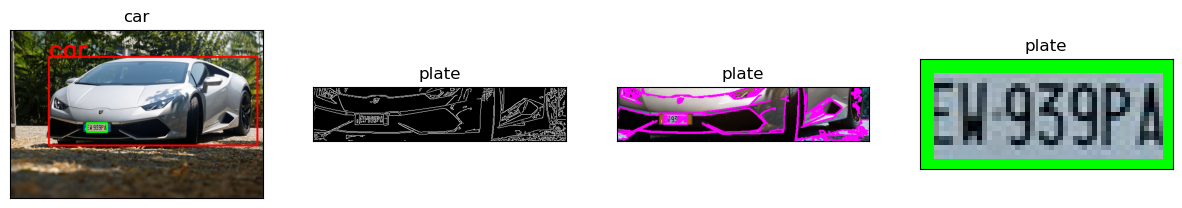


[+] MATRÍCULA DETECTADA: =W-939PA

--- Ejemplo 4 ---


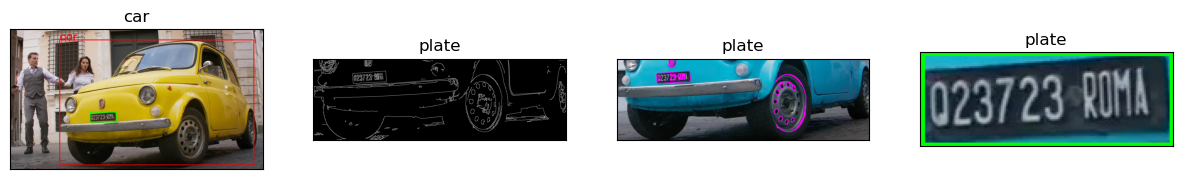


[+] MATRÍCULA DETECTADA: 023723-80Mh |

--- Ejemplo 5 ---


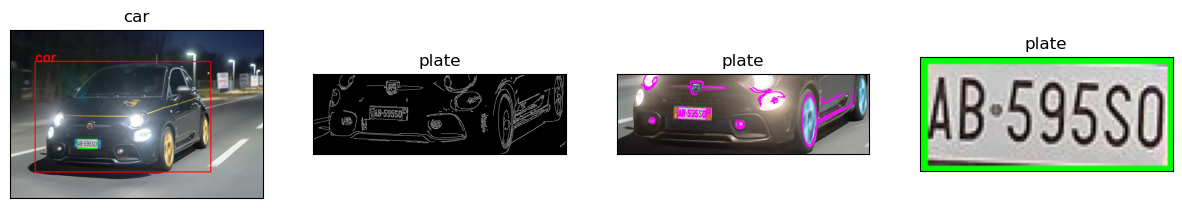


[+] MATRÍCULA DETECTADA: AB-595S0



In [32]:
print("--- Ejemplo 1 ---")
detector_plate(image="coche1.jpg", show_plot=False)

print("--- Ejemplo 2 ---")
detector_plate(image="coche2.jpg", show_plot=False)

print("--- Ejemplo 3 ---")
detector_plate(image="coche4.jpg", show_plot=False)

print("--- Ejemplo 4 ---")
detector_plate(image="coche6.jpg", show_plot=False)

print("--- Ejemplo 5 ---")
detector_plate(image="coche7.jpg", show_plot=False)
